## 🎙️ Introduction

As everybody should have heard of at least by now, is that Google released a new flagship model called [Gemini](https://blog.google/technology/ai/google-gemini-ai/). I won't go into its capabilities but rather into how to access it. Currently there is an API-Key role-out for [specific regions](https://ai.google.dev/available_regions) only. Those locations can [obtain an API-Key using the makersuite](https://makersuite.google.com/) **but all other countries below cannot!**

- 🇦🇫 Afghanistan
- 🇦🇱 Albania
- 🇦🇩 Andorra
- 🇧🇭 Bahrain
- 🇧🇾 Belarus
- 🇧🇪 Belgium
- 🇧🇦 Bosnia and Herzegovina
- 🇧🇬 Bulgaria
- 🇨🇳 China
- 🇭🇷 Croatia
- 🇨🇾 Cyprus
- 🇨🇿 Czech Republic
- 🇩🇰 Denmark
- 🇪🇪 Estonia
- 🇫🇮 Finland
- 🇫🇷 France
- 🇩🇪 Germany
- 🇬🇷 Greece
- 🇭🇺 Hungary
- 🇮🇸 Iceland
- 🇮🇪 Ireland
- 🇮🇹 Italy
- 🇱🇻 Latvia
- 🇱🇮 Liechtenstein
- 🇱🇹 Lithuania
- 🇱🇺 Luxembourg
- 🇲🇹 Malta
- 🇲🇩 Moldova
- 🇲🇨 Monaco
- 🇲🇪 Montenegro
- 🇳🇱 Netherlands
- 🇲🇰 North Macedonia (formerly Macedonia)
- 🇳🇴 Norway
- 🇵🇱 Poland
- 🇵🇹 Portugal
- 🇷🇴 Romania
- 🇷🇺 Russia
- 🇸🇲 San Marino
- 🇷🇸 Serbia
- 🇸🇰 Slovakia
- 🇸🇮 Slovenia
- 🇪🇸 Spain
- 🇸🇪 Sweden
- 🇨🇭 Switzerland
- 🇺🇦 Ukraine
- 🇬🇧 United Kingdom
- 🇻🇦 Vatican City (Holy See)

To provide a solution for the above-listed countries, I spent a weekend finding out how to access the Gemini Pro Model in a legitimate way for all developers around the globe **without API-KEY**!

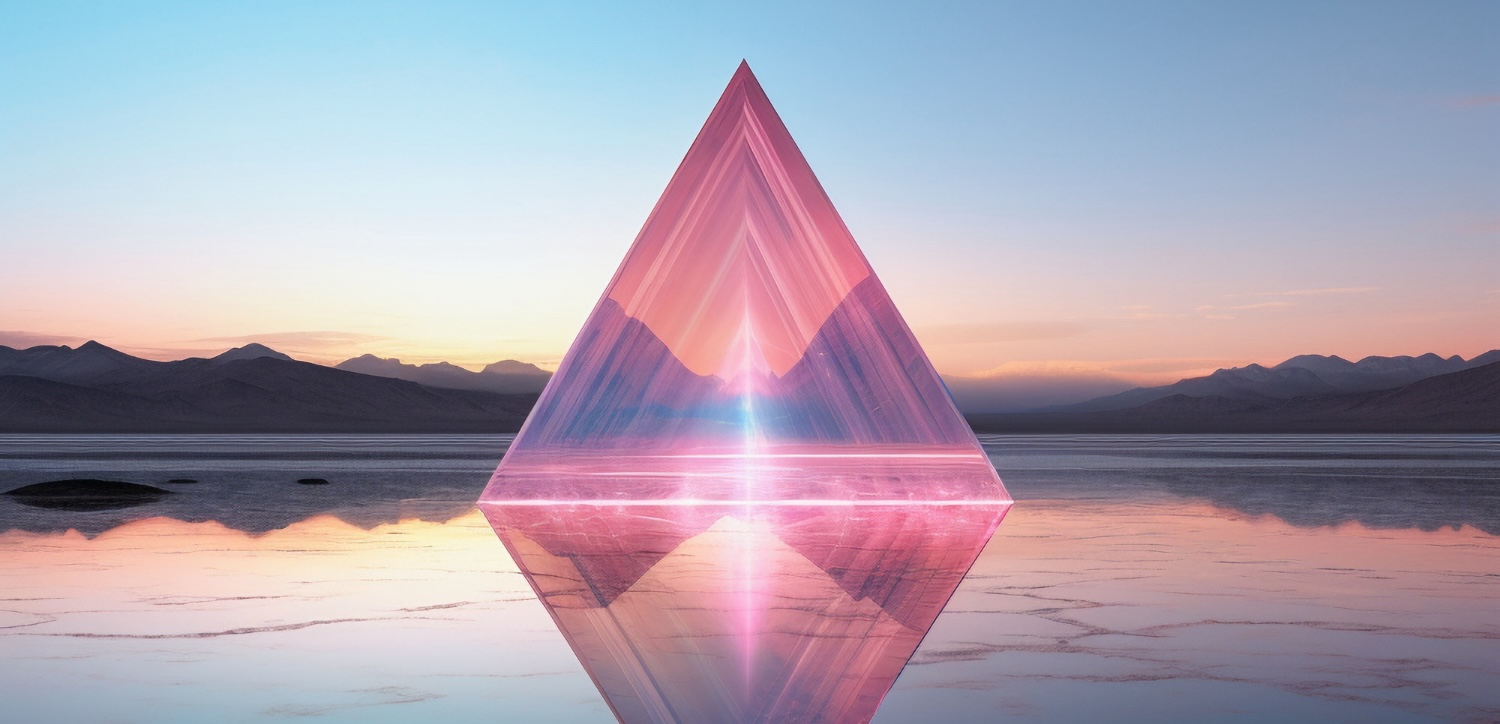
[Generated with Midjourney 5.2 by freepik]

## 🛒 What ingredients do we need?

- A Google Cloud Console Account - some regions offer $300 bucks trial balance, we don't need it!
- A credit card - for validation purpose if you need to create a new GCP account only!
- Some patients - nobody likes to read manuals but I tried to keep it concise ;)

After following the setup steps you are able to generate your first requests which will be exported in a file called `output.csv` by default.

**Let's begin!**

## ☁️ Setup on Google Cloud Platform (GCP)

#### Step 1: Create a Google Cloud Account

1. Go to the [Google Cloud Console](https://cloud.google.com/?hl=en).
2. Click on `Get Started for Free` if you don't have a Google Cloud account. Follow the prompts to create an account.

#### Step 2: Create a New Project

1. Once logged in, click on the project dropdown in the upper-left corner of the Cloud Console.
2. Click on the `New Project` button.
3. Enter a `Gemini Pro Project`, select an Organization if applicable, and choose a Location (region).
4. Click on the `Create` button.

#### Step 3: Enable Billing for the Project

1. In the Cloud Console, navigate to the `Billing` section.
2. Click on `Link a billing account` and follow the instructions to set up billing for your project.

#### Step 4: Enable APIs

1. In the Cloud Console, go to the `APIs & Services` -> `Dashboard` section.
2. Click on the `+ ENABLE APIS AND SERVICES` button.
3. Search for the APIs you need (e.g., `Cloud Storage API`, `AI Platform API`) and enable them.

#### Step 5: Create Service Account and Download Key File
1. In the Cloud Console, go to the `IAM & Admin` -> `Service accounts` section.
2. Click on `+ CREATE SERVICE ACCOUNT`.
3. Enter a Service account name, select a role (e.g., `Gemini Pro Project` -> `Owner` for full access), and click `Continue`.
4. Optionally, you can add additional permissions and click `Continue`.
5. Skip the `Grant users access to this service account` section and click `Done`.
6. Find the newly created service account in the list and click on the pencil icon (edit).
7. Navigate to the `Add Key` tab, select `JSON`, and click `Create`. This will download a JSON key file (`keyxxx.json`) which we need in the following part!

## 🌐 Setup Environment

#### Step 6: Set Environment Variable
1. Place the downloaded`keyxxx.json` file in the same directory as the notebook.

**Note:** In a productive environment we would use a Key-Vault to store credentials. Further in the code you will see a part where a the file is retrieved with the credentials. Even it's less secure, we don't use more strict requirements as it serves the sake of simplicity.

**Good news - You are done with paperwork!**

## 📡 Imports
Beside the installation of the latest Google Cloud AI Platform we have to install all needed dependencies.

In [1]:
pip install --upgrade google-cloud-aiplatform

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from google.cloud import aiplatform
from vertexai.preview.generative_models import GenerativeModel

## ⚙️ Environment Variables
- `project_id` - The ID of your project in which the credentials were created in.
- `location` - Locality of the used AI-Service.

**Note:** Adjust if needed.

In [3]:
project_id = 'gemini-pro-project'
location = 'us-central1'

In [4]:
aiplatform.init(project=project_id, location=location)

## ✨ Prompting - Make some magic!
Use the [Gemini-Pro-Model-Documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/gemini?hl=en) to make yourself familiar with all available parameters.

##### User depending parameters:
- `prompt` - Request the chatbot will respond to.
- `amount` - The number of Requests that will be sent with your set prompt.
- `step_size_saving` - The step size after how many generation cycles data will be appended to the csv file. This can be very useful in case generation runs into errors. The set default is 5.
- `delay` - The time each request has to wait before the next generation. Default is 5 seconds.
- `output_file` - Define the name of your exported csv file.

##### Model depending parameters:
- `temperature` - Temperature controls the degree of randomness in token selection. Lower temperatures are good for prompts that require a more deterministic and less open-ended or creative response, while higher temperatures can lead to more diverse or creative results.
- `top_k` - This parameter determines how the model selects tokens for output. For each token selection step, the top_k tokens with the highest probabilities are sampled. Then tokens are further filtered based on top-P with the final token selected using temperature sampling.
- `top_p` - Tokens are selected from the most (see top_k) to least probable, until the sum of their probabilities equals the top_p value.
- `max_output_tokens` - The amount of tokens that is used to generate your answer. 100 Tokens will approximately create 60-80 words

**Note:** The defined parameters are Google Standard values noted in their documentation:

In [5]:
prompt = 'What is reality, and how do we perceive it?'
amount = 10
step_size_saving = 5
delay = 5
output_file = 'output.csv'

temperature = 0.9
top_k = 32
top_p = 1
max_output_tokens = 8192

## 🛠️ Helper functions
- `file_existing_check()` - Checks if a csv file is already in the directory. If yes it will append the data to it (it will not replace/overwrite it - which is good news). Otherwise, if no file is found it will therefore create a new csv file with the above given name (output_file parameter).
- `inject_credentials()` - This function injects credentials to Google Cloud services and the `GOOGLE_APPLICATION_CREDENTIALS` environment variable.
- `save_dataframe_to_csv()` - It simple saves the dataframe with the generated to the csv file. In the iteration it is called after each set `step_size` value.

In [6]:
def file_existing_check():
    if os.path.exists(output_file):
        return pd.read_csv(output_file)
    else:
        return pd.DataFrame()

def inject_credentials():
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'key.json'
    
def save_dataframe_to_csv(dataframe):
    dataframe.to_csv(output_file, index=False)

## 🤖 Model and Generation
In this section we are using the Gemini Pro Model available in Vertex AI, which is requested to respond to our prompts iteratively. 

In [7]:

def model_and_generation():
    existing_df = file_existing_check()
    model = GenerativeModel("gemini-pro")

    generation_config = {
        "temperature": temperature,
        "top_k": top_k,
        "top_p": top_p,
        "max_output_tokens": max_output_tokens
    }

    for i in tqdm(range(1, amount + 1), file=sys.stdout, colour='green'):
        try:
            response = model.generate_content(prompt, generation_config=generation_config)
            existing_df = pd.concat([existing_df, pd.DataFrame({'prompt': [prompt],'text': [response.text]})], ignore_index=True)

            if i % step_size_saving == 0:
                save_dataframe_to_csv(existing_df)

        except Exception as e:
            print(f'Error: {e}')
            time.sleep(delay)
            continue
            
    save_dataframe_to_csv(existing_df)

## 🏛️ Core
Finally, we reached the main function. It reads the credentials and the text generation is triggered which runs until all cycles are completed.

In [8]:
if __name__ == '__main__':
    
    try:
        inject_credentials()
        model_and_generation()
    except IOError as e:
        print(f'IOError: {e}')
    finally:
        print('### - Generation Finished - ###')

100%|███████████████████████████████████████████| 10/10 [01:38<00:00,  9.82s/it]
### - Generation Finished - ###


## 🤝 Final word
Congratulations on reaching this point and reading through it! I consistently prioritize quality over quantity. Your feedback and input are, as always, greatly appreciated. Let's make this world a better place in a collaborative open-source manner.

Thank you for every reaction - it means a lot! 🙌

## ⚖️ Disclaimer
Use this notebook and Google Cloud Console at your own risk. I am not responsible for any financial charges that may occur as a result of running the provided code. Please ensure you understand the costs associated with the services used in this notebook, and monitor your usage to avoid unexpected charges.